In [12]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

from pyspark.sql.functions import col
import pyspark.sql.functions as F

import pandas as pd
from functools import reduce
from pyspark.sql import DataFrame


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
def gen_data(n,a,b,mu_x,sigma_x,sigma_e):
    x= np.random.normal(mu_x,sigma_x,[n,1])
    e= np.random.normal(0,sigma_e,[n,1])
    y  = a*x+b+e
    return x,y

n1=200
x1,y1 = gen_data(n=n1,a=-1,b=3,mu_x=-1,sigma_x=2,sigma_e=1)

n2=300
x2,y2 = gen_data(n=n2,a=-0.7,b=13,mu_x=5,sigma_x=2,sigma_e=1)

n3=50
x3,y3 = gen_data(n=n3,a=-1.7,b=27,mu_x=8,sigma_x=2,sigma_e=0.5)

n4=250
x4,y4 = gen_data(n=n4,a=-1.9,b=-5,mu_x=-5,sigma_x=1.5,sigma_e=0.5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
XY=[[x1,y1],[x2,y2],[x3,y3],[x4,y4]]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Show the Dataset**

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

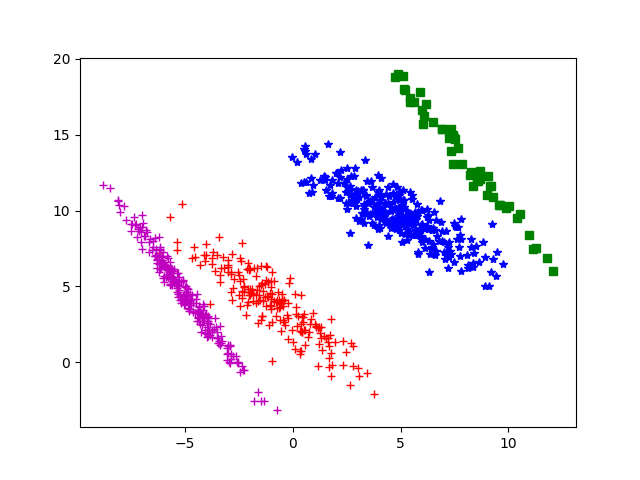

In [4]:
plt.plot(x1,y1,'r+')
plt.plot(x2,y2,'b*')
plt.plot(x3,y3,'gs')
plt.plot(x4,y4,'m+')

%matplot plt

In [5]:
def calc_A(x):
    A = np.hstack([x,np.ones_like(x)])
    return A

def calc_AT_times_A(A):
    term1 = np.matmul(A.T,A)
    return term1

def calc_AT_times_y(A,y):
    term2 = np.matmul(A.T,y)
    return term2

def solve_lin_regession(x,y):
    
    A = calc_A(x)
    
    term1 = calc_AT_times_A(A)
    term2 = calc_AT_times_y(A,y)
    theta = np.matmul(np.linalg.inv(term1),term2)
    
    yhat=np.matmul(A,theta)
    return yhat

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

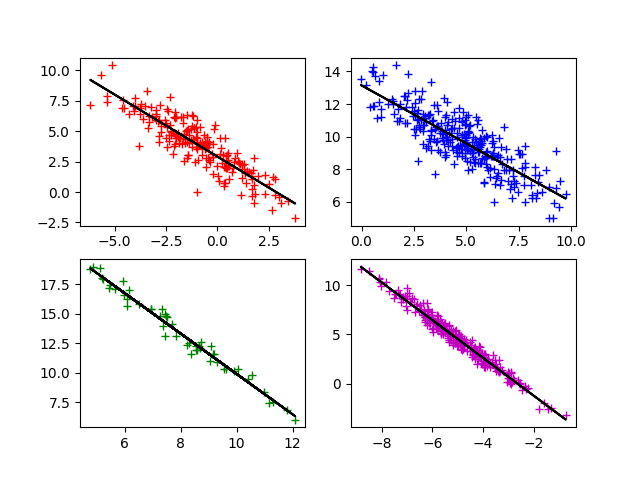

In [8]:
fig, axs = plt.subplots(2, 2)


yhat1=solve_lin_regession(x1,y1)
yhat2=solve_lin_regession(x2,y2)
yhat3=solve_lin_regession(x3,y3)
yhat4=solve_lin_regession(x4,y4)


axs[0][0].plot(x1,y1,'r+')
axs[0][0].plot(x1,yhat1,'k-')

axs[0][1].plot(x2,y2,'b+')
axs[0][1].plot(x2,yhat2,'k-')

axs[1][0].plot(x3,y3,'g+')
axs[1][0].plot(x3,yhat3,'k-')

axs[1][1].plot(x4,y4,'m+')
axs[1][1].plot(x4,yhat4,'k-')

%matplot plt

In [9]:
print(len(x1),len(x2),len(x3),len(x4))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

200 300 50 250

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

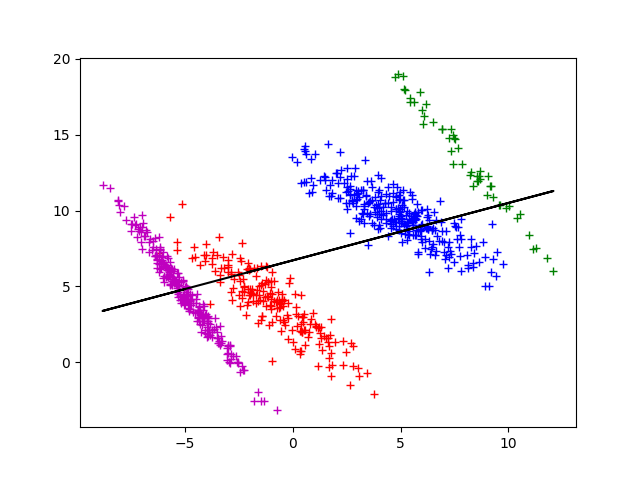

In [10]:
fig, axs = plt.subplots(1, 1)

allX=np.concatenate([x1,x2,x3,x4])
allY=np.concatenate([y1,y2,y3,y4])

allYhat=solve_lin_regession(allX,allY)

plt.plot(x1,y1,'r+')
plt.plot(x2,y2,'b+')
plt.plot(x3,y3,'g+')
plt.plot(x4,y4,'m+')


plt.plot(allX,allYhat,'k-')
%matplot plt

### Distributed Linear Regression

Put each of the 4 datasets into one partititon

In [13]:
df = pd.DataFrame(np.squeeze(np.stack([x1,np.ones_like(x1),y1])).T, columns=list('1xy'))
sp_df_part1=spark.createDataFrame(df).repartition(1)

df = pd.DataFrame(np.squeeze(np.stack([x2,np.ones_like(x2),y2])).T, columns=list('1xy'))
sp_df_part2=spark.createDataFrame(df).repartition(1)

df = pd.DataFrame(np.squeeze(np.stack([x3,np.ones_like(x3),y3])).T, columns=list('1xy'))
sp_df_part3=spark.createDataFrame(df).repartition(1)

df = pd.DataFrame(np.squeeze(np.stack([x4,np.ones_like(x4),y4])).T, columns=list('1xy'))
sp_df_part4=spark.createDataFrame(df).repartition(1)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# join the partitions

dfs = [sp_df_part1,sp_df_part2,sp_df_part3,sp_df_part4]
allparts_df = reduce(DataFrame.unionAll, dfs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# number of points
print(allparts_df.count())

# number of partititons
print(allparts_df.rdd.getNumPartitions())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

800
4

In [17]:
# show the date
allparts_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---+-----------------+
|                  1|  x|                y|
+-------------------+---+-----------------+
| -4.653608807350203|1.0|6.900411853484873|
| -0.510672852963759|1.0|4.194748948019339|
|-3.3541066760032496|1.0|5.299792005186818|
|-0.5708616526361817|1.0|3.618014692105367|
| -4.096061584180227|1.0|7.101674976209813|
+-------------------+---+-----------------+
only showing top 5 rows

 $$\textrm{Calculate the inner products: } A^TA \textrm{ and } A^Ty$$

In [18]:
df=allparts_df
colDFs = []
for c2 in ['1','x']:
    colDFs.append( df.select( [ F.sum(df[c1]*df[c2]).alias("result_{0}".format(c1)) for c1 in ['1','x','y'] ] ) )
# now union those separate data frames to build the "matrix"
mtxDF = reduce(lambda a,b: a.select(a.columns).union(b.select(a.columns)), colDFs )
mtxDF.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+------------------+-----------------+
|         result_1|          result_x|         result_y|
+-----------------+------------------+-----------------+
|19239.68263683974|383.31473874795824|9857.765359968493|
|383.3147387479582|             800.0| 5516.67895673838|
+-----------------+------------------+-----------------+

In [19]:
results=np.asarray(mtxDF.collect())
results

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[19239.68263684,   383.31473875,  9857.76535997],
       [  383.31473875,   800.        ,  5516.67895674]])

In [20]:
spark_term1 = results[0:2,0:2]
spark_term2 = results[:,2]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
print(spark_term1)
print(spark_term2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[19239.68263684   383.31473875]
 [  383.31473875   800.        ]]
[9857.76535997 5516.67895674]

**Check if it is the same as what we would get with standard numpy using all data**

In [22]:
A = calc_A(allX)
np_term1 = calc_AT_times_A(A)
print(np_term1)

### Yayy, np_term1 is the same as spark_term1!

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[19239.68263684   383.31473875]
 [  383.31473875   800.        ]]

In [23]:
np_term2 = calc_AT_times_y(A,allY)
print(np_term2)

### Yayy, np_term2 is the same as spark_term2!


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[9857.76535997]
 [5516.67895674]]

In [24]:
theta = np.matmul(np.linalg.inv(spark_term1),spark_term2)
allYhat=np.matmul(A,theta)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

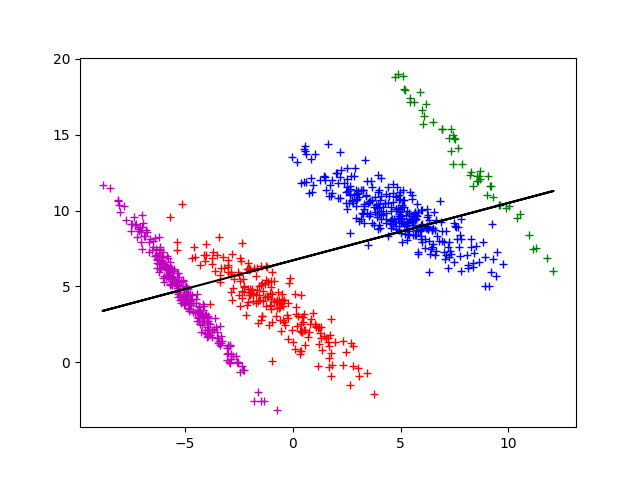

In [25]:
fig, axs = plt.subplots(1, 1)


plt.plot(x1,y1,'r+')
plt.plot(x2,y2,'b+')
plt.plot(x3,y3,'g+')
plt.plot(x4,y4,'m+')

#plt.plot(allX,allY,'r+')
plt.plot(allX,allYhat,'k-')
%matplot plt